<a href="https://colab.research.google.com/github/elylaila/seminario/blob/main/best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Seminario

/content/drive/MyDrive/Seminario


# Data loading

In [60]:
df_dev = load_dataset("csv", data_files="dataset/df_train_clean.csv")
df_test = load_dataset("csv", data_files="dataset/df_test_clean.csv")

In [61]:
df_dev = df_dev.rename_column("homotransphobic", "labels")
df_test = df_test.rename_column("homotransphobic", "labels")

# Model loading

In [62]:
%ls

alberto_ita_hate_speech_default-finetuned/  final_model-finetuned/
bert_base_italian-finetuned/                hate_ita_default-finetuned/
bert_ita_default-finetuned/                 hate-italian-finetuned/
class_report_bert_ita_default.html          loss_bert_ita_default.html
class_report_distilbert_ita_default.html    loss_curves_bert_ita_default.pdf
conf_matrix_bert_ita_default.pdf            loss_curves_distilbert_ita_default.pdf
conf_matrix_distilbert_ita_default.pdf      loss_distilbert_ita_default.html
dataset/                                    setfit_italian_hatespeech_default-finetuned/
distilbert_ita_default-finetuned/


In [63]:
nome = 'final_model' # modificare
model = 'dbmdz/bert-base-italian-cased'

In [64]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model)

# Data preprocessing

In [65]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [66]:
tokenized_dev = df_dev.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

In [67]:
tokenized_dev = tokenized_dev['train']
tokenized_dev

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5000
})

In [68]:
tokenized_test = tokenized_test['train']
tokenized_test

Dataset({
    features: ['text', 'labels', 'rationales', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

# Training

In [69]:
training_args = TrainingArguments(
    output_dir=f"{nome}-finetuned",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    save_strategy = "epoch",
    logging_strategy="epoch",
    num_train_epochs=10,
    load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
    metric_for_best_model='eval_f1',
    seed=42,
    # per_device_train_batch_size = 2, # default 8
    # per_device_eval_batch_size = 2 # default 8
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0 # disastro
    )

In [70]:
config = AutoConfig.from_pretrained(model)

In [71]:
print(config)

BertConfig {
  "_name_or_path": "dbmdz/bert-base-italian-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}



In [72]:
model = AutoModelForSequenceClassification.from_pretrained(model, config=config)

model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [73]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [74]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dev,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

In [75]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.526100,0.650224,0.742303
2,0.394600,0.783767,0.718058
3,0.288900,0.927987,0.765657
4,0.184300,1.039088,0.774171
5,0.097200,1.029108,0.799415
6,0.059400,1.345206,0.779893
7,0.035000,1.541930,0.782314
8,0.017500,1.673728,0.788966
9,0.014100,1.628772,0.789757
10,0.003500,1.740991,0.791891


CPU times: user 1h 22min 45s, sys: 26.7 s, total: 1h 23min 12s
Wall time: 1h 27min 24s


TrainOutput(global_step=6250, training_loss=0.16207446407318116, metrics={'train_runtime': 5244.1376, 'train_samples_per_second': 9.534, 'train_steps_per_second': 1.192, 'total_flos': 1.3155552768e+16, 'train_loss': 0.16207446407318116, 'epoch': 10.0})

# Evaluation

In [76]:
log_history = trainer.state.log_history

In [77]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df_train = pd.DataFrame({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, index=[0])
    df = pd.concat([df, df_train], ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df_val = pd.DataFrame({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, index=[0])
    df = pd.concat([df, df_val], ignore_index=True)
df


,Epoch,Loss,Dataset
0,1,0.526100,Training
1,1,0.650224,Validation
2,2,0.394600,Training
3,2,0.783767,Validation
4,3,0.288900,Training
5,3,0.927987,Validation
6,4,0.184300,Training
7,4,1.039088,Validation
8,5,0.097200,Training
9,5,1.029108,Validation


In [78]:
from transformers.modelcard import parse_log_history

In [79]:
his = parse_log_history(log_history)

In [80]:
df_his = pd.DataFrame(his[1], columns=['Step','Epoch', 'Training Loss', 'Validation Loss', 'F1'])

In [81]:
df_his

,Step,Epoch,Training Loss,Validation Loss,F1
0,625,1.0,0.5261,0.650224,0.742303
1,1250,2.0,0.3946,0.783767,0.718058
2,1875,3.0,0.2889,0.927987,0.765657
3,2500,4.0,0.1843,1.039088,0.774171
4,3125,5.0,0.0972,1.029108,0.799415
5,3750,6.0,0.0594,1.345206,0.779893
6,4375,7.0,0.0350,1.541930,0.782314
7,5000,8.0,0.0175,1.673728,0.788966
8,5625,9.0,0.0141,1.628772,0.789757
9,6250,10.0,0.0035,1.740991,0.791891


In [ ]:
df.to_html(f'loss_{nome}.html')

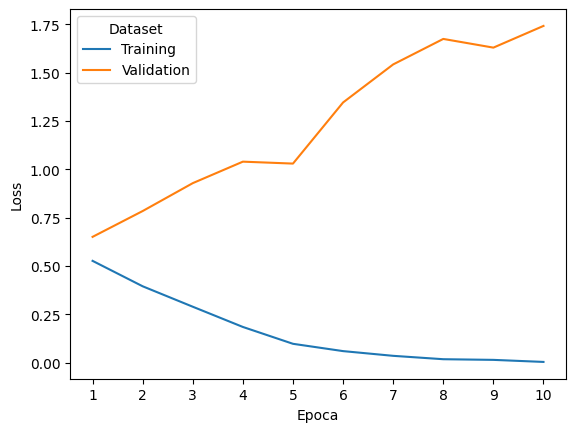

In [83]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 11))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [84]:
output_predictions = trainer.predict(tokenized_test)

In [85]:
y_true = tokenized_test["labels"]
y_pred = np.argmax(output_predictions.predictions, axis=1)

In [86]:
predictions = {'y_true': y_true, 'y_pred': y_pred}

In [89]:
df_predictions = pd.DataFrame(data=predictions)
df_predictions

,y_true,y_pred
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
995,0,0
996,0,1
997,0,0
998,1,1


In [90]:
df_predictions.to_csv(f'{nome}_predictions.csv')

In [91]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       489
           1       0.86      0.73      0.79       511

    accuracy                           0.80      1000
   macro avg       0.81      0.80      0.80      1000
weighted avg       0.81      0.80      0.80      1000



In [92]:
with open(f"class_report_{nome}.txt", "w") as file:
    file.write(report)

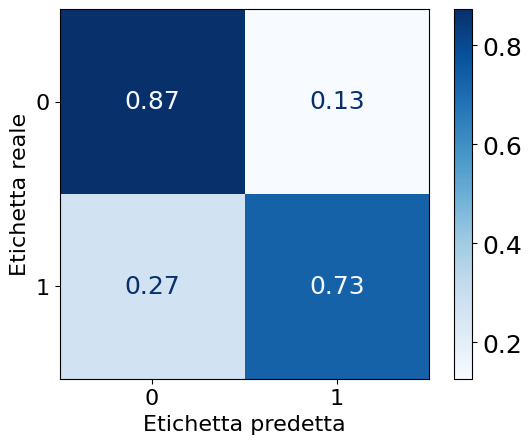

In [93]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()